In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from deeplearing_model import ModelSaver,EarlyStopping,plot_learning_curves,plot_learning_loss_curves
from deeplearing_model import evaluate_milti_output_model,train_milti_output_model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# 准备数据

In [2]:
# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据拆分：训练集(64%)、验证集(16%)、测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

训练集大小: 13209
验证集大小: 3303
测试集大小: 4128


In [3]:
# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 自定义数据集类
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).view(-1, 1)
        
    def __len__(self):
        return len(self.features) #返回样本数量
    
    def __getitem__(self, idx): #传入索引，返回对应索引样本的特征和目标
        return self.features[idx], self.targets[idx]

# 创建数据集实例
train_dataset = HousingDataset(X_train_scaled, y_train)
val_dataset = HousingDataset(X_val_scaled, y_val)
test_dataset = HousingDataset(X_test_scaled, y_test)

In [4]:
# Adam优化器的特点
"""
Adam优化器的特点
1. 自适应学习率 - 为每个参数计算不同的学习率，适应性强
2. 结合了动量Momentum和RMSProp的优点 - 加速收敛并处理稀疏梯度
3. 偏差修正 - 修正初始训练阶段的估计偏差
4. 计算效率高 - 计算量小，内存需求低
5. 超参数稳健 - 默认超参数通常工作良好，不需要频繁调整
"""

# Adam优化器参数说明
"""
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
参数解释：
- lr: 学习率，控制参数更新步长,默认: 0.001
- betas: 用于计算梯度及其平方的运行平均值的系数,默认: (0.9, 0.999)
- eps: 添加到分母以提高数值稳定性的项,默认: 1e-8
- weight_decay: 权重衰减L2惩罚,默认: 0
"""

'\noptimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)\n参数解释：\n- lr: 学习率，控制参数更新步长,默认: 0.001\n- betas: 用于计算梯度及其平方的运行平均值的系数,默认: (0.9, 0.999)\n- eps: 添加到分母以提高数值稳定性的项,默认: 1e-8\n- weight_decay: 权重衰减L2惩罚,默认: 0\n'

In [12]:
# 创建数据加载器
batch_size = 64  # 每批处理的样本数量
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 训练数据加载器，打乱数据
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # 验证数据加载器
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # 测试数据加载器

# 定义WideDeep神经网络模型,多输出模型
class WideDeepgModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
    
        
        # Deep部分 - 使用Sequential构建多层神经网络
        self.deep = nn.Sequential(
            nn.Linear(input_size, 30),  # 第一层隐藏层
            nn.ReLU(),
            nn.Dropout(0.2),  # 第一层添加dropout，防止过拟合
            nn.Linear(30, 30),  # 第二层隐藏层
            nn.ReLU()
        )
        self.output = nn.Linear(30 + input_size, 1)
        
    def forward(self, x):
        # Wide部分直接线性映射
        wide_output = x # 宽路径输出
        
        # Deep部分使用Sequential处理
        deep_output = self.deep(x)  # Deep部分的最终输出
        
        # 连接Wide和Deep,combined shape是[batch_size, 30 + input_dim]
        combined = torch.cat([wide_output, deep_output], dim=1)
        
        # 输出层，输出shape是[batch_size, 1]
        output = self.output(combined)
        # 返回两个输出：最终输出(wide+deep)和deep特征
        return output, deep_output  # 返回合并输出和输入特征

# 初始化模型
input_size = X_train.shape[1]  # 特征数量，8列数据
model = WideDeepgModel(input_size) #初始化模型，输入8列数据，输出1列数据

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失函数，适用于回归问题
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器，学习率为0.001

# 打印模型结构
print(model)

WideDeepgModel(
  (deep): Sequential(
    (0): Linear(in_features=8, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU()
  )
  (output): Linear(in_features=38, out_features=1, bias=True)
)


In [13]:


early_stopping = EarlyStopping(patience=10, verbose=True)
model_saver = ModelSaver(save_dir='model_weights')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, record_dict = train_milti_output_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100,
    eval_step=500,
    early_stopping=early_stopping,
    model_saver=model_saver,
    device=device
)

  0%|          | 0/20700 [00:00<?, ?it/s]

d:\python\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([39, 1])) that is different to the input size (torch.Size([39, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


早停触发!
1.4935
早停: 已有5轮验证损失没有改善！


In [7]:
train_loss = evaluate_milti_output_model(model, train_loader,device, criterion)
val_loss= evaluate_milti_output_model(model, val_loader,device, criterion)
test_loss = evaluate_milti_output_model(model, test_loader,device, criterion)

print(f"训练集 - 均方误差: {train_loss:.4f}")
print(f"验证集 - 均方误差: {val_loss:.4f}")
print(f"测试集 - 均方误差: {test_loss:.4f}")

d:\python\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\python\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


训练集 - 均方误差: 0.7209
验证集 - 均方误差: 0.8028
测试集 - 均方误差: 0.7499


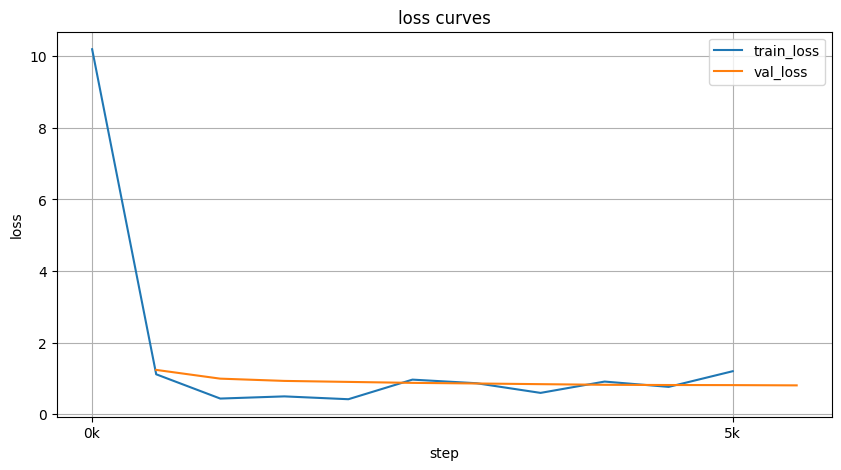

In [8]:
#画图
plot_learning_loss_curves(record_dict,sample_step=500)


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_loss=evaluate_milti_output_model(model,test_loader,device,criterion)
print(f"测试集上的损失为{test_loss:.4f}")

测试集上的损失为0.7499


d:\python\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\python\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
